In [411]:
import numpy as np
import matplotlib.pyplot as plt
import graph_tool as gt

from histogram_of_integers import hist
import csv
from tqdm import tqdm
from IPython import display

import graph_tool.clustering as gtc
import graph_tool.generation as gtg
import graph_tool.draw as gtd

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

In [412]:
#import graphs and labels
    
def string_to_list(string):
    """given a string of two elements, returns each element in a list"""
    return [int(string.split(' ')[0]), int(string.split(' ')[1])]

#100 cities
n = 100
G_list = np.array([gt.Graph(directed = False) for i in range(n)], dtype = object)
o_f = '/Users/endingalaporte/Desktop/graphlet_kernel/input'
for i in range(n):
    open_path = o_f + "/edgelist_city"+str(i)+".txt"
    #print(open_path)
    text = open(open_path, 'r')
    reader = csv.reader(text, delimiter='\n')
    elist = [string_to_list(row[0]) for row in reader]
    G_list[i].add_edge_list(elist)
    
#100 labels
label_path = '/Users/endingalaporte/Desktop/graphlet_kernel/input/communes_littorales.txt'
text = open(label_path, 'r')
reader = csv.reader(text, delimiter='\n')
labels = np.array([int(row[0]) for row in reader])
labels = labels[0:len(G_list)]

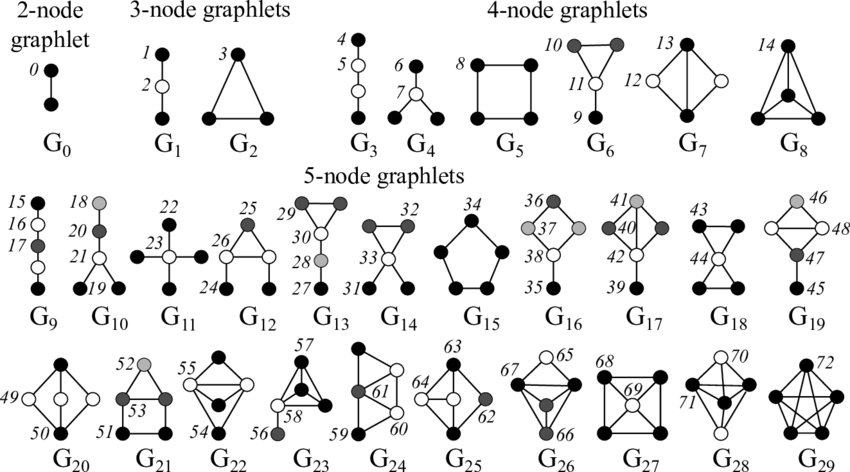

In [413]:
#345graphlets
graphlets = [g1,g2,g3,g4,g5,g6,g7,g8, g9, g10, g11, g12, g13, g14, 
             g15, g16, g17, g18, g19, g20,
             g21, g22, g23, g24, g25, g26, g27, g28, g29]
graphlets = np.array(graphlets, dtype = object)

graphlets3 = graphlets[0:2] #3-graphlets
graphlets4 = graphlets[2:8] #4-graphlets
graphlets5 = graphlets[8:29] #5-graphlets

display.Image("/Users/endingalaporte/Desktop/graphlet_kernel/src/image/graphlets.png")

In [414]:
#phi transform a graph to a size 29 vector of 345graphlet counts
def phi_345graphlet(G : gt.Graph):
    """given graph G, returns the graphlet count vector for all 29 3,4,5-graphlets"""
    _, counts3 = gtc.motifs(G, p = 1.0, motif_list = graphlets3, k = 3)
    _, counts4 = gtc.motifs(G, p = 1.0, motif_list = graphlets4, k = 4)
    _, counts5 = gtc.motifs(G, p = 1.0, motif_list = graphlets5, k = 5)
    counts345 = np.concatenate((counts3,counts4,counts5), axis = 0)
    return counts345

def phi_345graphlet_normalized(G : gt.Graph):
    """
    given graph G, returns the normalized
    graphlet count vector for all connected 3,4,5-graphlets
    """
    _, counts3 = gtc.motifs(G, p = 1.0, motif_list = graphlets3, k = 3)
    _, counts4 = gtc.motifs(G, p = 1.0, motif_list = graphlets4, k = 4)
    _, counts5 = gtc.motifs(G, p = 1.0, motif_list = graphlets5, k = 5)
    counts345 = np.concatenate((counts3,counts4,counts5), axis = 0)
    counts345 = counts345/counts345.sum()
    return counts345

100it [01:16,  1.30it/s]


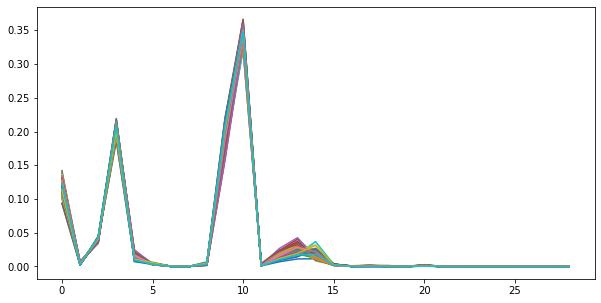

In [422]:
#visualize the phi vector of each city
all_phi = np.zeros([n,len(graphlets)])

for i,g in tqdm(enumerate(G_list)):
    all_phi[i] = phi_345graphlet_normalized(g)
    
plt.figure(figsize = (10,5))
for i in range(len(all_phi)):
    plt.plot(all_phi[i])

No handles with labels found to put in legend.


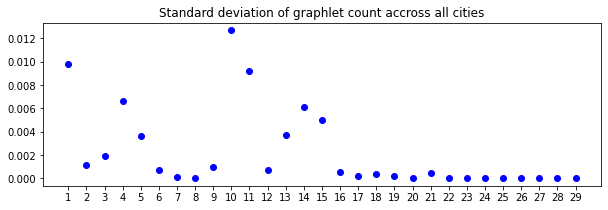

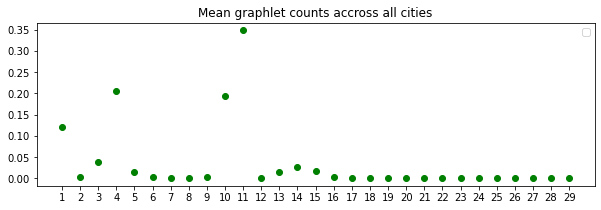

In [416]:
#standard deviation and mean of all phi vectors
std = []
mean = []
for i in range(len(all_phi[0])):
    std.append(all_phi[:,i].std())
    mean.append(all_phi[:,i].mean())

plt.figure(figsize=(10, 3))
plt.title("Standard deviation of graphlet count accross all cities")
plt.scatter(np.arange(1, len(std)+1),std, c = 'b')
plt.xticks(np.arange(1, 30, 1))

plt.figure(figsize=(10, 3))
plt.title("Mean graphlet counts accross all cities")
plt.scatter(np.arange(1, len(mean)+1),mean, c = 'g')
plt.xticks(np.arange(1, 30, 1))
plt.legend()

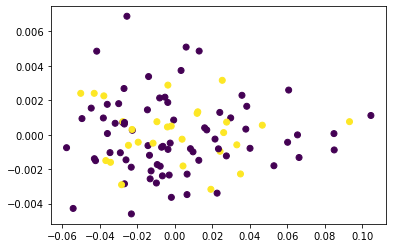

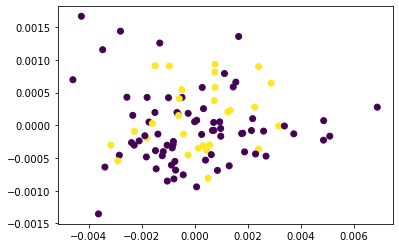

In [417]:
#kernel matrix K
K = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        K[i,j] = np.dot(all_phi[i], all_phi[j])
        
#PCA using kernel matrix K

output = '/Users/endingalaporte/Desktop/graphlet_kernel/output/'
reducer = PCA(n_components = 3)
embed = reducer.fit_transform(K)
plt.scatter(embed[:,0], embed[:,1], c = labels, marker = "o")
plt.savefig(output + '12dim_pca_345graphlet_normalized_kernel.svg')
plt.subplots()
plt.scatter(embed[:,1], embed[:,2], c = labels, marker = "o")
plt.savefig(output + '23dim_pca_345graphlet_normalized_kernel.svg')

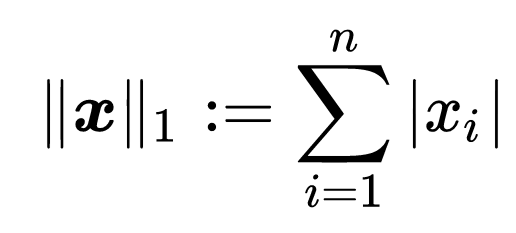

In [418]:
display.Image("/Users/endingalaporte/Desktop/graphlet_kernel/src/image/l1_manhattan_norm.png")

/Users/endingalaporte/Documents/python/miniconda3/envs/jupyternotebookenv/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


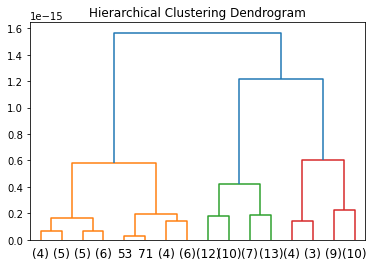

In [419]:
#distance matrix D
D = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        D[i,j] = abs((all_phi[i]-all_phi[j]).sum()) #l1 Manhattan norm

#dendogram from distance matrix D

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(D)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.show()

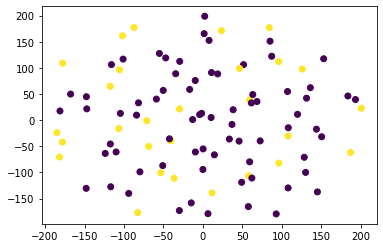

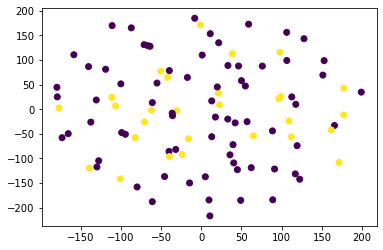

In [420]:
#TSNE from distance matrix D
model = TSNE(n_components = 3)
model.fit(D)
ed = model.fit_transform(D)
plt.scatter(ed[:,0], ed[:,1], c = labels)
plt.subplots()
plt.scatter(ed[:,1], ed[:,2], c = labels)

In [ ]:
#TRASH

def draw(G : gt.Graph):
    """given graph_tool graph, draw it"""
    gtd.graph_draw(G, output_size = (100,100))
    
#gt.centrality.motifs permit to count the number of given graphlet (subgraph isomorphism VF2 algorithm)
#when the graph is too big, we can even sample the graphlets given a probability p 

H = g9
elist = []
for e in H.edges():
    elist.append([int(e.source()),int(e.target())])
elist = np.array(elist)
np.savetxt("/Users/endingalaporte/Desktop/graphlet_kernel/src/graphlets/g9_edgelist.txt", 
               elist, fmt="%d")


"""
k = 5 #size of graphlets
i = 1 #i-th graph of the dataset

motifs, counts = gtc.motifs(gt.GraphView(G_list[7], directed=False), k)
print("there are",len(motifs),"graphlets of size",k)
for h in range(len(motifs)):
    print("The count of this below graphlet is",counts[h])
    gtd.graph_draw(motifs[h], output_size = (100,100))
"""

"""

#G20, G22, G23, G26,G27, G28, G29
g20 = gt.Graph(directed = False)
g22 = gt.Graph(directed = False)
g23 = gt.Graph(directed = False)
g26 = gt.Graph(directed = False)
g27 = gt.Graph(directed = False)
g28 = gt.Graph(directed = False)

g20.add_edge_list([[0,1],[1,2],[2,3],[3,0],[3,4],[4,1]])
g22.add_edge_list([[0,1],[1,2],[2,3],[3,0],[2,4],[2,0],[4,0]])
g23.add_edge_list([[0,1],[1,2],[2,3],[3,1],[4,1],[4,2],[4,3]])
g26.add_edge_list([[0,1],[1,2],[2,3],[3,0],[1,3],[4,0],[4,1],[4,3]])
g27.add_edge_list([[0,1],[1,2],[2,3],[3,0],[4,0],[4,1],[4,2],[4,3]])
g28.add_edge_list([[0,1],[1,2],[2,3],[3,0],[0,2],[4,0],[4,1],[4,2],[4,3]])
g29 = gtg.complete_graph(5)


draw(g29)
"""
graphlet4 = gt.Graph(directed = False)
graphlet4.add_edge_list([[0,1],[1,2],[2,0],[0,3],[1,3],[2,3]])
gtd.graph_draw(graphlet4, output_size = (100,100))

sample_counts = []
for i in range(10):
    print(round((i+1)*0.1, 1))
    motifs, counts = gtc.motifs(gt.GraphView(G_list[0], directed=False), p = round((i+1)*0.1, 1), motif_list = [graphlet4], k = 4)
    sample_counts.append(counts)

sample_counts = np.array(sample_counts)
sample_counts

hist(np.array([1,1,1,1]))

G_list_test = [gtg.circular_graph(6, 1), gtg.lattice((2,3)), gtg.complete_graph(30)] #dataset
for h in range(len(G_list_test)):
    print(h,"-th graph")
    gtd.graph_draw(G_list_test[h], output_size = (100,100))